*This notebook plots the lastmile latency by time of day and last-mile latency by timezone*
- - - 

In [164]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [165]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [166]:
import sqlite3
import pandas as pd

In [167]:
DB_LOCATION = 'lastmile.db'

In [168]:
METADATA_SNAPSHOT = 'metadata_snapshot'
METADATA_SNAPSHOT_EXTENSIONS = 'metadata_snapshot_extensions'
SK_ASN = 'sk_asn'
SK_ONE_OFF_EXTENSIONS = 'sk_one_off_extensions'
SK_LATENCIES_AGG = 'sk_latencies_agg'
UNIT_REPORT = 'unit_report'

In [169]:
con = sqlite3.connect(DB_LOCATION)

In [170]:
query_sk = '''SELECT      agg.probeid
                        , agg.timestamp
--                      , unit.latitude || ';' || unit.longitude as latlon
                        , s.asn
                        , meta.product
                        , s.asn_holder_name
                        , s.asn_access_type                
                        , ext.access_type_technology
                        , agg.h1_avg || ';' || agg.h2_avg as h1h2

               FROM   %s                             as  agg
                    , %s                             as  api
                    , %s                             as  s
                    , %s                             as  meta
                    , %s                             as  ext
--                  , %s                             as  unit

               WHERE     agg.probeid                  =  api.probeid
               AND       agg.probeid                  =  ext.probeid
               AND       api.asn                      =  s.asn
               AND       agg.probeid                  =  meta.id
--             AND       agg.probeid                  =  unit.unit_id
               

               AND       ext.if_residential           =  1
               AND       agg.h1_avg                   <>   0
               AND       agg.h2_avg                   <>   0

               
            '''%(  SK_LATENCIES_AGG
                 , METADATA_SNAPSHOT_EXTENSIONS
                 , SK_ASN
                 , METADATA_SNAPSHOT
                 , SK_ONE_OFF_EXTENSIONS
                 , UNIT_REPORT
                )

df_sk = pd.read_sql(query_sk, con)

In [171]:
df_sk.count()

probeid                   435841
timestamp                 435841
asn                       435841
product                   435841
asn_holder_name           435841
asn_access_type           415903
access_type_technology    102512
h1h2                      435841
dtype: int64

In [172]:
df_sk.head()

,probeid,timestamp,asn,product,asn_holder_name,asn_access_type,access_type_technology,h1h2
0,14905,2014-07-28 00:36:14,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.794;7.423
1,14905,2014-07-28 00:36:18,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.787;7.41
2,14905,2014-07-28 12:36:52,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.786;7.687
3,14905,2014-07-28 12:36:56,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.808;7.539
4,14905,2014-07-28 16:36:10,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.813;7.576


In [173]:
df_sk = df_sk.dropna(subset = ['h1h2'])

In [174]:
df_sk.count()

probeid                   435841
timestamp                 435841
asn                       435841
product                   435841
asn_holder_name           435841
asn_access_type           415903
access_type_technology    102512
h1h2                      435841
dtype: int64

In [175]:
df_sk.head()

,probeid,timestamp,asn,product,asn_holder_name,asn_access_type,access_type_technology,h1h2
0,14905,2014-07-28 00:36:14,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.794;7.423
1,14905,2014-07-28 00:36:18,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.787;7.41
2,14905,2014-07-28 12:36:52,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.786;7.687
3,14905,2014-07-28 12:36:56,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.808;7.539
4,14905,2014-07-28 16:36:10,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.813;7.576


In [176]:
def calculate_lastmile_latency(h1h2):
    try: h1,h2 = h1h2.split(';')
    except Exception as e: print(e, type(e), h1h2); return None
    
    try: lastmile = float(h2) - float(h1)
    except Exception as e: print(e, type(e), h1, h2); return None
    
    return lastmile

In [177]:
df_sk['lastmile'] = df_sk['h1h2'].apply(calculate_lastmile_latency)

In [178]:
df_sk.head()

,probeid,timestamp,asn,product,asn_holder_name,asn_access_type,access_type_technology,h1h2,lastmile
0,14905,2014-07-28 00:36:14,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.794;7.423,6.629
1,14905,2014-07-28 00:36:18,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.787;7.41,6.623
2,14905,2014-07-28 12:36:52,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.786;7.687,6.901
3,14905,2014-07-28 12:36:56,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.808;7.539,6.731
4,14905,2014-07-28 16:36:10,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,0.813;7.576,6.763


In [179]:
df_sk.count()

probeid                   435841
timestamp                 435841
asn                       435841
product                   435841
asn_holder_name           435841
asn_access_type           415903
access_type_technology    102512
h1h2                      435841
lastmile                  435841
dtype: int64

In [180]:
del df_sk['h1h2']

In [181]:
df_sk.count()

probeid                   435841
timestamp                 435841
asn                       435841
product                   435841
asn_holder_name           435841
asn_access_type           415903
access_type_technology    102512
lastmile                  435841
dtype: int64

In [182]:
df_sk.head()

,probeid,timestamp,asn,product,asn_holder_name,asn_access_type,access_type_technology,lastmile
0,14905,2014-07-28 00:36:14,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,6.629
1,14905,2014-07-28 00:36:18,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,6.623
2,14905,2014-07-28 12:36:52,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,6.901
3,14905,2014-07-28 12:36:56,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,6.731
4,14905,2014-07-28 16:36:10,2856,40,"BT-UK-AS BT Public Internet Service,GB",DSL,None,6.763


In [183]:
df_sk_probes_access_type = df_sk[['probeid', 'asn_access_type', 'access_type_technology']].drop_duplicates()

In [184]:
d = []
def myfunc(x):
    count = 0
    manual = x['asn_access_type']; rdns = x['access_type_technology']
    
    chosen = None
    if manual is None and rdns is None: chosen = None
    elif manual is None and rdns is not None: chosen = rdns
    elif manual is not None and rdns is None: chosen = manual
    elif manual == rdns: chosen = rdns
    elif manual != rdns:
        if rdns == 'FIBRE': chosen = rdns    
        else: d.append(x['probeid']); 
    else: print('wow!')   
        
    return chosen

In [185]:
df_sk_probes_access_type['chosen'] = df_sk_probes_access_type.apply(myfunc, axis=1)
print(set(d));

{141472, 143020, 143084, 143508, 147324, 146332}


In [186]:
del df_sk['asn_access_type']; del df_sk_probes_access_type['asn_access_type']
del df_sk['access_type_technology']; del df_sk_probes_access_type['access_type_technology']

In [187]:
df_sk_probes_access_type.count()

probeid    1245
chosen     1189
dtype: int64

In [188]:
df_sk_probes_access_type = df_sk_probes_access_type.dropna()

In [189]:
df_sk_probes_access_type.count()

probeid    1189
chosen     1189
dtype: int64

In [190]:
df_sk_probes_access_type.head()

,probeid,chosen
0,14905,DSL
418,14971,DSL
564,15015,DSL
978,15058,DSL
1304,15129,DSL


In [191]:
df_sk.count()

probeid            435841
timestamp          435841
asn                435841
product            435841
asn_holder_name    435841
lastmile           435841
dtype: int64

In [192]:
df_sk.head()

,probeid,timestamp,asn,product,asn_holder_name,lastmile
0,14905,2014-07-28 00:36:14,2856,40,"BT-UK-AS BT Public Internet Service,GB",6.629
1,14905,2014-07-28 00:36:18,2856,40,"BT-UK-AS BT Public Internet Service,GB",6.623
2,14905,2014-07-28 12:36:52,2856,40,"BT-UK-AS BT Public Internet Service,GB",6.901
3,14905,2014-07-28 12:36:56,2856,40,"BT-UK-AS BT Public Internet Service,GB",6.731
4,14905,2014-07-28 16:36:10,2856,40,"BT-UK-AS BT Public Internet Service,GB",6.763


In [193]:
df_sk_probes_asn = df_sk[['probeid', 'asn', 'asn_holder_name']].drop_duplicates()

In [194]:
df_sk_probes_asn.count()

probeid            1245
asn                1245
asn_holder_name    1245
dtype: int64

In [195]:
df_sk_probes_asn.head()

,probeid,asn,asn_holder_name
0,14905,2856,"BT-UK-AS BT Public Internet Service,GB"
418,14971,12576,ORANGE-PCS Orange Personal Communications Serv...
564,15015,2856,"BT-UK-AS BT Public Internet Service,GB"
978,15058,2856,"BT-UK-AS BT Public Internet Service,GB"
1304,15129,6871,"PLUSNET PlusNet PLC,GB"


In [196]:
def create_pretty_node_names(asn, holder):
    
    d = {
          'NTL'        : 'VIRGINMEDIA'
        , 'AS3215'     : 'ORANGE'        
        , 'VODANET'    : 'VODAFONE'
        , 'PROXAD'     : 'FREE'
        , 'ROADRUNNER' : 'TWC'
        , 'TDDE'       : 'TELEFONICA-DE'
        , 'TT'         : 'TALKTALK'
        , 'AS20712'    : 'A&A'
        
    }
    
    firstname = holder.split('-')[0].split(' ')[0]
    try: firstname = d[firstname]
    except Exception as e: pass
    
    if 'AS' in str(asn): nodename = '%s (%s)'%(firstname, asn)
    else: nodename = '%s (AS%s)'%(firstname, asn)
    return nodename

def myfunc(x):
    asn = x['asn']; holder = x['asn_holder_name']; 
    nodename = create_pretty_node_names(asn, holder)
    x['nodename'] = nodename
    return x

df_sk_probes_asn = df_sk_probes_asn.apply(myfunc, axis=1)

In [197]:
del df_sk_probes_asn['asn']; del df_sk['asn']
del df_sk_probes_asn['asn_holder_name']; del df_sk['asn_holder_name']

In [198]:
df_sk_probes_asn.count()

probeid     1245
nodename    1245
dtype: int64

In [199]:
df_sk_probes_asn.head()

,probeid,nodename
0,14905,BT (AS2856)
418,14971,ORANGE (AS12576)
564,15015,BT (AS2856)
978,15058,BT (AS2856)
1304,15129,PLUSNET (AS6871)


In [200]:
df_sk.count()

probeid      435841
timestamp    435841
product      435841
lastmile     435841
dtype: int64

In [201]:
df_sk = pd.merge(df_sk, df_sk_probes_asn, on='probeid', how='outer')
df_sk = pd.merge(df_sk, df_sk_probes_access_type, on='probeid', how='outer')

In [202]:
df_sk.count()

probeid      435841
timestamp    435841
product      435841
lastmile     435841
nodename     435841
chosen       416973
dtype: int64

In [203]:
df_sk.head()

,probeid,timestamp,product,lastmile,nodename,chosen
0,14905,2014-07-28 00:36:14,40,6.629,BT (AS2856),DSL
1,14905,2014-07-28 00:36:18,40,6.623,BT (AS2856),DSL
2,14905,2014-07-28 12:36:52,40,6.901,BT (AS2856),DSL
3,14905,2014-07-28 12:36:56,40,6.731,BT (AS2856),DSL
4,14905,2014-07-28 16:36:10,40,6.763,BT (AS2856),DSL


In [204]:
df_sk = df_sk.dropna()

In [205]:
df_sk.count()

probeid      416973
timestamp    416973
product      416973
lastmile     416973
nodename     416973
chosen       416973
dtype: int64

In [206]:
df_sk.head()

,probeid,timestamp,product,lastmile,nodename,chosen
0,14905,2014-07-28 00:36:14,40,6.629,BT (AS2856),DSL
1,14905,2014-07-28 00:36:18,40,6.623,BT (AS2856),DSL
2,14905,2014-07-28 12:36:52,40,6.901,BT (AS2856),DSL
3,14905,2014-07-28 12:36:56,40,6.731,BT (AS2856),DSL
4,14905,2014-07-28 16:36:10,40,6.763,BT (AS2856),DSL


In [207]:
query_sk = '''SELECT      unit_id as 'probeid'
                        , GROUP_CONCAT(unit.region) as cities
  
               FROM   %s                             as  unit
                    , %s                             as  ext
                    , %s                             as  agg 

               WHERE     agg.probeid                  =  ext.probeid
               AND       ext.probeid                  =  unit.unit_id
               AND       ext.if_residential           =  1
               AND       agg.h1_avg                   <>   0
               AND       agg.h2_avg                   <>   0
               AND       unit.region                  <> ''

               GROUP BY unit_id
               
            '''%(  UNIT_REPORT
                 , SK_ONE_OFF_EXTENSIONS
                 , SK_LATENCIES_AGG
                )

df_sk_geo = pd.read_sql(query_sk, con)

In [208]:
df_sk_geo = df_sk_geo.drop_duplicates()

In [209]:
df_sk_geo.count()

probeid    1064
cities     1064
dtype: int64

In [210]:
def get_uniq_city(city):
    if city is None: return None
    else: return list(set(city.split(',')))[0] ## -- here I am getting the first city only
    
df_sk_geo['city'] = df_sk_geo['cities'].apply(get_uniq_city)

In [211]:
del df_sk_geo['cities']

In [212]:
df_sk_geo.head()

,probeid,city
0,14905,Midlothian
1,14971,Edinburgh
2,15015,Sheffield
3,15058,Lincolnshire
4,15163,Somerset


In [213]:
df_sk = pd.merge(df_sk, df_sk_geo, on='probeid', how='outer')

In [214]:
df_sk.count()

probeid      417011
timestamp    416973
product      416973
lastmile     416973
nodename     416973
chosen       416973
city         359994
dtype: int64

In [215]:
df_sk = df_sk.dropna()

In [216]:
df_sk.count()

probeid      359956
timestamp    359956
product      359956
lastmile     359956
nodename     359956
chosen       359956
city         359956
dtype: int64

In [217]:
df_sk.head()

,probeid,timestamp,product,lastmile,nodename,chosen,city
0,14905,2014-07-28 00:36:14,40,6.629,BT (AS2856),DSL,Midlothian
1,14905,2014-07-28 00:36:18,40,6.623,BT (AS2856),DSL,Midlothian
2,14905,2014-07-28 12:36:52,40,6.901,BT (AS2856),DSL,Midlothian
3,14905,2014-07-28 12:36:56,40,6.731,BT (AS2856),DSL,Midlothian
4,14905,2014-07-28 16:36:10,40,6.763,BT (AS2856),DSL,Midlothian


In [218]:
from datetime import datetime
def timestamp_string_to_datetime(timestamp_str):
    date_object = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S')
    return date_object

df_sk['datetime'] = df_sk['timestamp'].apply(timestamp_string_to_datetime)

In [219]:
del df_sk['timestamp']

In [220]:
df_sk['hour'] = df_sk['datetime'].apply(lambda date: date.hour)

In [221]:
df_sk.head()

,probeid,product,lastmile,nodename,chosen,city,datetime,hour
0,14905,40,6.629,BT (AS2856),DSL,Midlothian,2014-07-28 00:36:14,0
1,14905,40,6.623,BT (AS2856),DSL,Midlothian,2014-07-28 00:36:18,0
2,14905,40,6.901,BT (AS2856),DSL,Midlothian,2014-07-28 12:36:52,12
3,14905,40,6.731,BT (AS2856),DSL,Midlothian,2014-07-28 12:36:56,12
4,14905,40,6.763,BT (AS2856),DSL,Midlothian,2014-07-28 16:36:10,16


In [222]:
df_sk['hour'] = df_sk['hour'].apply(lambda h: '%02dh'%h)

In [223]:
df_sk[['probeid']] = df_sk[['probeid']].astype(str)

In [224]:
df_sk_dsl   = df_sk[df_sk.chosen == 'DSL']
df_sk_cable = df_sk[df_sk.chosen == 'CABLE']
df_sk_fibre = df_sk[df_sk.chosen == 'FIBRE']

In [225]:
df_sk_dsl.head()

,probeid,product,lastmile,nodename,chosen,city,datetime,hour
0,14905.0,40,6.629,BT (AS2856),DSL,Midlothian,2014-07-28 00:36:14,00h
1,14905.0,40,6.623,BT (AS2856),DSL,Midlothian,2014-07-28 00:36:18,00h
2,14905.0,40,6.901,BT (AS2856),DSL,Midlothian,2014-07-28 12:36:52,12h
3,14905.0,40,6.731,BT (AS2856),DSL,Midlothian,2014-07-28 12:36:56,12h
4,14905.0,40,6.763,BT (AS2856),DSL,Midlothian,2014-07-28 16:36:10,16h


In [226]:
df_sk_dsl_hour_gby   = df_sk_dsl.groupby('hour')
df_sk_cable_hour_gby = df_sk_cable.groupby('hour')
sk_dsl_probes_by_hour   = ['%d'%len(set(v['probeid'].values)) for k, v in df_sk_dsl_hour_gby] 
sk_cable_probes_by_hour = ['%d'%len(set(v['probeid'].values)) for k, v in df_sk_cable_hour_gby] 

In [227]:
def stop_plot_box(ax, chosen, count, probes_by_hour = [], platform = '-', savefig = True):
    
    ax2 = ax.twinx()
    ax.set_title(""); plt.suptitle("")
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels( probes_by_hour, fontsize = 22)
    ax2.yaxis.set_label_position("right")    
    ax2.set_ylabel('[# Probes]', fontsize=22)
   
    xticks = [1, 2, 4, 8, 16, 32, 64]
    ax.grid(False)
    ax.set_xlim([1, 64])
    ax.set_xscale('log', basex=2)
    if chosen != 'CABLE': ax.set_ylabel('[%d probes]'%count, fontsize=22)
    if chosen == 'CABLE': ax.set_ylabel('[%d]'%count, fontsize=22)        
    ax.set_xlabel('Last-mile latency (ms)', fontsize=22)
    ax.yaxis.set_label_position("left")    
    ax.set_ylabel('[35 days]', fontsize=22)    
    plt.xticks(xticks, xticks)    
    plt.suptitle('')
    plt.title('%s (%s)'%(chosen, platform), fontsize=22, y=1.05)
    if platform == 'RIPE Atlas' : platform = 'ra'
    if platform == 'SamKnows'   : platform = 'sk'
    if savefig: plt.savefig('%s-%s-lastmile-latency-hour-boxplot.pdf'%(platform, chosen), format='pdf', bbox_inches='tight')
    return ax2

In [228]:
def start_plot_box(width=5, height=10):    
    # ---- plt.style.use('ggplot')
    fig = plt.figure(figsize=(width,height))
    plt.rcParams['font.size'] = 22
    ax = fig.add_subplot(111)
    return ax

In [229]:
len(set(df_sk_dsl['probeid'].values))

833

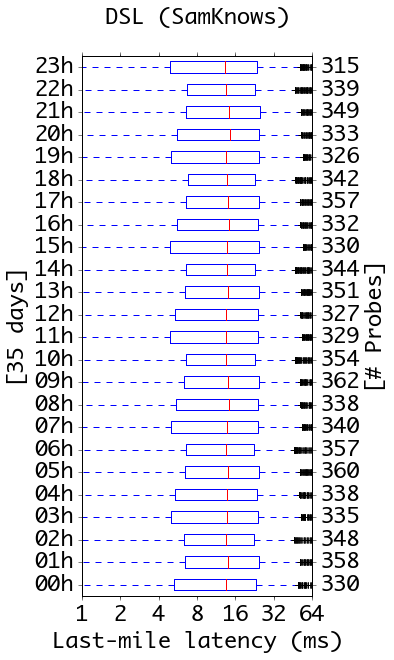

In [230]:
ax = start_plot_box(width = 4)

a  = df_sk_dsl.boxplot (  column='lastmile'
                        , by=['hour']
                        , ax=ax
                        , vert=False
                       )

stop_plot_box(a, chosen='DSL', count = 0, probes_by_hour = sk_dsl_probes_by_hour, platform = 'SamKnows')

In [232]:
df_sk_cable_gby_nodename = df_sk_cable.groupby('nodename')
df_sk_dsl_gby_nodename   = df_sk_dsl.groupby('nodename')

In [233]:
def get_frac_probes_by_nodename_within_city(provider):

    def num_probes(x):
        probeids = "%s" % ','.join(x)
        return len(set(probeids.split(',')))

    provider_gby   = provider.groupby('city')
    provider_city_probes  =   provider_gby['probeid'].agg([num_probes])
    
    provider  =   pd.merge(provider, provider_city_probes, left_on='city', right_index=True)    
    provider_probes    =   len(set(provider['probeid'].values))
    provider['frac_probes']   = provider['num_probes']   / provider_probes
    return provider

In [235]:
RA_PROBE = 'ra_probe'
RA_PROBE_API = 'ra_probe_api'
RA_ASN = 'ra_asn'
RA_ONE_OFF_EXTENSIONS = 'ra_one_off_extensions'
RA_LATENCIES_AGG = 'ra_latencies_agg'

In [236]:
query_ra = '''SELECT      agg.probeid
                        , agg.timestamp
                        , api.latitude || ';' || api.longitude as latlon                        
                        , s.asn
                        , s.asn_holder_name
                        , s.asn_access_type                
                        , ext.access_type_technology
                        , agg.h1_median || ';' || agg.h2_median as h1h2

               FROM   %s                             as  agg
                    , %s                             as  api
                    , %s                             as  s               
                    , %s                             as  hardware
                    , %s                             as  ext

               WHERE     agg.probeid                  =  api.probeid
               AND       agg.probeid                  =  hardware.probeid
               AND       agg.probeid                  =  ext.probeid
               AND       api.asn_v4                   =  s.asn

               AND       hardware.hardware_version    =  'v3'
               AND       ext.if_residential           =  1

               
            '''%(  RA_LATENCIES_AGG
                 , RA_PROBE_API
                 , RA_ASN
                 , RA_PROBE
                 , RA_ONE_OFF_EXTENSIONS
                )

df_ra = pd.read_sql(query_ra, con)

In [237]:
df_ra.count()

probeid                   134724
timestamp                 134724
latlon                    134724
asn                       134724
asn_holder_name           134724
asn_access_type           134724
access_type_technology     43963
h1h2                      130006
dtype: int64

In [238]:
df_ra.head()

,probeid,timestamp,latlon,asn,asn_holder_name,asn_access_type,access_type_technology,h1h2
0,10006,1406548034,52.3805;4.9275,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.429;20.49
1,10006,1406562432,52.3805;4.9275,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.431;17.7
2,10006,1406576835,52.3805;4.9275,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.438;17.776
3,10006,1406591230,52.3805;4.9275,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.478;17.577
4,10006,1406605631,52.3805;4.9275,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,0.422;17.526


In [239]:
df_ra = df_ra.dropna(subset = ['h1h2'])

In [240]:
df_ra.count()

probeid                   130006
timestamp                 130006
latlon                    130006
asn                       130006
asn_holder_name           130006
asn_access_type           130006
access_type_technology     40625
h1h2                      130006
dtype: int64

In [241]:
def calculate_lastmile_latency(h1h2):
    try: h1,h2 = h1h2.split(';')
    except Exception as e: print(e, type(e), h1h2); return None
    
    try: lastmile = float(h2) - float(h1)
    except Exception as e: print(e, type(e), h1, h2); return None
    
    return lastmile

In [242]:
df_ra['lastmile'] = df_ra['h1h2'].apply(calculate_lastmile_latency)

In [243]:
del df_ra['h1h2']

In [244]:
df_ra.head()

,probeid,timestamp,latlon,asn,asn_holder_name,asn_access_type,access_type_technology,lastmile
0,10006,1406548034,52.3805;4.9275,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,20.061
1,10006,1406562432,52.3805;4.9275,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,17.269
2,10006,1406576835,52.3805;4.9275,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,17.338
3,10006,1406591230,52.3805;4.9275,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,17.099
4,10006,1406605631,52.3805;4.9275,3265,"XS4ALL-NL XS4ALL Internet BV,NL",DSL,DSL,17.104


In [245]:
df_ra.count()

probeid                   130006
timestamp                 130006
latlon                    130006
asn                       130006
asn_holder_name           130006
asn_access_type           130006
access_type_technology     40625
lastmile                  130006
dtype: int64

In [246]:
df_ra_probes_access_type = df_ra[['probeid', 'asn_access_type', 'access_type_technology']].drop_duplicates()

In [247]:
df_ra_probes_access_type.head()

,probeid,asn_access_type,access_type_technology
0,10006,DSL,DSL
208,10007,CABLE,CABLE
370,10010,CABLE,None
570,10012,DSL,None
778,10013,DSL,DSL


In [248]:
d = []
def myfunc(x):
    count = 0
    manual = x['asn_access_type']; rdns = x['access_type_technology']
    
    chosen = None
    if manual is None and rdns is None: chosen = None
    elif manual is None and rdns is not None: chosen = rdns
    elif manual is not None and rdns is None: chosen = manual
    elif manual == rdns: chosen = rdns
    elif manual != rdns:
        if rdns == 'FIBRE': chosen = rdns    
        else: d.append(x['probeid']); 
    else: print('wow!')   
        
    return chosen

In [249]:
df_ra_probes_access_type['chosen'] = df_ra_probes_access_type.apply(myfunc, axis=1)
print(set(d));

{10151}


In [250]:
df_ra_probes_access_type.count()

probeid                   691
asn_access_type           691
access_type_technology    221
chosen                    690
dtype: int64

In [251]:
del df_ra['asn_access_type']; del df_ra_probes_access_type['asn_access_type']; 
del df_ra['access_type_technology']; del df_ra_probes_access_type['access_type_technology']; 

In [252]:
df_ra_probes_access_type = df_ra_probes_access_type.dropna()

In [253]:
df_ra_probes_access_type.count()

probeid    690
chosen     690
dtype: int64

In [254]:
df_ra_probes_access_type.head()

,probeid,chosen
0,10006,DSL
208,10007,CABLE
370,10010,CABLE
570,10012,DSL
778,10013,DSL


In [255]:
df_ra.count()

probeid            130006
timestamp          130006
latlon             130006
asn                130006
asn_holder_name    130006
lastmile           130006
dtype: int64

In [256]:
df_ra_probes_asn = df_ra[['probeid', 'asn', 'asn_holder_name']].drop_duplicates()

In [257]:
df_ra_probes_asn.count()

probeid            691
asn                691
asn_holder_name    691
dtype: int64

In [258]:
df_ra_probes_asn.head()

,probeid,asn,asn_holder_name
0,10006,3265,"XS4ALL-NL XS4ALL Internet BV,NL"
208,10007,7922,"COMCAST-7922 - Comcast Cable Communications, I..."
370,10010,6830,"LGI-UPC Liberty Global Operations B.V.,AT"
570,10012,3265,"XS4ALL-NL XS4ALL Internet BV,NL"
778,10013,3265,"XS4ALL-NL XS4ALL Internet BV,NL"


In [259]:
def create_pretty_node_names(asn, holder):
    
    d = {
          'NTL'        : 'VIRGINMEDIA'
        , 'AS3215'     : 'ORANGE'        
        , 'VODANET'    : 'VODAFONE'
        , 'PROXAD'     : 'FREE'
        , 'ROADRUNNER' : 'TWC'
        , 'TDDE'       : 'TELEFONICA-DE'
        , 'TT'         : 'TALKTALK'
    }
    
    firstname = holder.split('-')[0].split(' ')[0]
    try: firstname = d[firstname]
    except Exception as e: pass
    
    if 'AS' in str(asn): nodename = '%s (%s)'%(firstname, asn)
    else: nodename = '%s (AS%s)'%(firstname, asn)
    return nodename

def myfunc(x):
    asn = x['asn']; holder = x['asn_holder_name']; 
    nodename = create_pretty_node_names(asn, holder)
    x['nodename'] = nodename
    return x

df_ra_probes_asn = df_ra_probes_asn.apply(myfunc, axis=1)

In [260]:
del df_ra['asn']; del df_ra_probes_asn['asn']
del df_ra['asn_holder_name']; del df_ra_probes_asn['asn_holder_name']

In [261]:
df_ra_probes_asn.count()

probeid     691
nodename    691
dtype: int64

In [262]:
df_ra_probes_asn.head()

,probeid,nodename
0,10006,XS4ALL (AS3265)
208,10007,COMCAST (AS7922)
370,10010,LGI (AS6830)
570,10012,XS4ALL (AS3265)
778,10013,XS4ALL (AS3265)


In [263]:
df_ra.count()

probeid      130006
timestamp    130006
latlon       130006
lastmile     130006
dtype: int64

In [264]:
df_ra.head()

,probeid,timestamp,latlon,lastmile
0,10006,1406548034,52.3805;4.9275,20.061
1,10006,1406562432,52.3805;4.9275,17.269
2,10006,1406576835,52.3805;4.9275,17.338
3,10006,1406591230,52.3805;4.9275,17.099
4,10006,1406605631,52.3805;4.9275,17.104


In [265]:
df_ra_probes_geo = df_ra[['probeid', 'latlon']].drop_duplicates()

In [266]:
df_ra_probes_geo.count()

probeid    691
latlon     691
dtype: int64

In [267]:
df_ra_probes_geo.head()

,probeid,latlon
0,10006,52.3805;4.9275
208,10007,38.3205;-122.3225
370,10010,52.3475;4.9175
570,10012,52.3685;4.8975
778,10013,52.3685;5.2175


In [268]:
d = {}
df_temp = pd.read_csv('ripeatlas-probes-timezones.csv')
for k, v in df_temp.iterrows(): 
    d[v['latlon']] = v['tz']

from tzwhere import tzwhere
def get_tzname_from_lat_lon_using_tzwhere(latlon):
    try: 
        lat, lon = latlon.split(';')
        tz = tzwhere.tzwhere().tzNameAt(float(lat), float(lon))
        print('.', end='')
    except Exception as e: print('*', end=''); tz = None
    return tz

import requests
def get_tzname_from_lat_lon(latlon):
    try: tz = d[latlon]
    except KeyError as e:
        try: 
            lat, lon = latlon.split(';')
            url = 'http://api.geonames.org/timezoneJSON?lat=%f&lng=%f&username=demo'
            res = requests.get(url%(float(lat), float(lon)))
            tz = res.json()['timezoneId']
            print('.', end='')
        except Exception as e: 
            tz = get_tzname_from_lat_lon_using_tzwhere(latlon)
    return tz

In [269]:
df_ra_probes_geo['tz'] = df_ra_probes_geo['latlon'].apply(get_tzname_from_lat_lon)

In [270]:
def get_city_from_lat_lon(latlon):
    lat, lon = latlon.split(';')
    url = "http://maps.googleapis.com/maps/api/geocode/json?"
    url += "latlng=%s,%s&sensor=false" % (lat, lon)
    try: res = requests.get(url)
    except Exception as e: print('*', end=''); return None
    j = res.json()
    try: components = j['results'][0]['address_components']
    except Exception as e: print('-', end=''); return None
    town = None
    for c in components: 
        if "locality" in c['types']: town = c['long_name']
    if town is None: print('^', end=''); return None
    else: print('.', end=''); return town

In [271]:
df_ra_probes_geo[df_ra_probes_geo['tz'].isnull() == False].count()

probeid    691
latlon     691
tz         691
dtype: int64

In [272]:
df_ra_probes_geo[df_ra_probes_geo['tz'].isnull() == True].count()

probeid    0
latlon     0
tz         0
dtype: int64

In [273]:
df_ra_probes_geo = df_ra_probes_geo.reset_index(drop=True)
df_ra_probes_geo.to_csv('ripeatlas-probes-timezones.csv')

In [274]:
del df_ra['latlon']; del df_ra_probes_geo['latlon']

In [275]:
df_ra_probes_geo.head()

,probeid,tz
0,10006,Europe/Amsterdam
1,10007,America/Los_Angeles
2,10010,Europe/Amsterdam
3,10012,Europe/Amsterdam
4,10013,Europe/Amsterdam


In [276]:
df_ra = pd.merge(df_ra, df_ra_probes_asn, on='probeid', how='outer')
df_ra = pd.merge(df_ra, df_ra_probes_access_type, on='probeid', how='outer')
df_ra = pd.merge(df_ra, df_ra_probes_geo, on='probeid', how='outer')

In [277]:
df_ra.count()

probeid      130006
timestamp    130006
lastmile     130006
nodename     130006
chosen       129820
tz           130006
dtype: int64

In [278]:
df_ra = df_ra.dropna()

In [279]:
df_ra.count()

probeid      129820
timestamp    129820
lastmile     129820
nodename     129820
chosen       129820
tz           129820
dtype: int64

In [280]:
df_ra.head()

,probeid,timestamp,lastmile,nodename,chosen,tz
0,10006,1406548034,20.061,XS4ALL (AS3265),DSL,Europe/Amsterdam
1,10006,1406562432,17.269,XS4ALL (AS3265),DSL,Europe/Amsterdam
2,10006,1406576835,17.338,XS4ALL (AS3265),DSL,Europe/Amsterdam
3,10006,1406591230,17.099,XS4ALL (AS3265),DSL,Europe/Amsterdam
4,10006,1406605631,17.104,XS4ALL (AS3265),DSL,Europe/Amsterdam


In [281]:
from datetime import datetime
def timestamp_to_datetime(timestamp):
    return datetime.fromtimestamp(int(timestamp))

df_ra['datetime'] = df_ra['timestamp'].apply(timestamp_to_datetime)

In [282]:
del df_ra['timestamp']

In [283]:
df_ra.count()

probeid     129820
lastmile    129820
nodename    129820
chosen      129820
tz          129820
datetime    129820
dtype: int64

In [284]:
df_ra.head()

,probeid,lastmile,nodename,chosen,tz,datetime
0,10006,20.061,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 13:47:14
1,10006,17.269,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 17:47:12
2,10006,17.338,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 21:47:15
3,10006,17.099,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-29 01:47:10
4,10006,17.104,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-29 05:47:11


In [285]:
df_ra['hour'] = df_ra['datetime'].apply(lambda date: date.hour)

In [286]:
df_ra.head()

,probeid,lastmile,nodename,chosen,tz,datetime,hour
0,10006,20.061,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 13:47:14,13
1,10006,17.269,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 17:47:12,17
2,10006,17.338,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 21:47:15,21
3,10006,17.099,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-29 01:47:10,1
4,10006,17.104,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-29 05:47:11,5


In [287]:
df_ra.count()

probeid     129820
lastmile    129820
nodename    129820
chosen      129820
tz          129820
datetime    129820
hour        129820
dtype: int64

In [288]:
df_ra[['probeid']] = df_ra[['probeid']].astype(str)

In [289]:
df_ra['hour'] = df_ra['hour'].apply(lambda h: '%02dh'%h)

In [290]:
df_ra_dsl   = df_ra[df_ra.chosen == 'DSL']
df_ra_cable = df_ra[df_ra.chosen == 'CABLE']
df_ra_fibre = df_ra[df_ra.chosen == 'FIBRE']

In [291]:
df_ra_dsl.head()

,probeid,lastmile,nodename,chosen,tz,datetime,hour
0,10006,20.061,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 13:47:14,13h
1,10006,17.269,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 17:47:12,17h
2,10006,17.338,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 21:47:15,21h
3,10006,17.099,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-29 01:47:10,01h
4,10006,17.104,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-29 05:47:11,05h


In [292]:
df_ra_dsl_hour_gby   = df_ra_dsl.groupby('hour')
df_ra_cable_hour_gby = df_ra_cable.groupby('hour')
df_ra_fibre_hour_gby = df_ra_fibre.groupby('hour')

ra_dsl_probes_by_hour   = ['%d'%len(set(v['probeid'].values)) for k, v in df_ra_dsl_hour_gby] 
ra_cable_probes_by_hour = ['%d'%len(set(v['probeid'].values)) for k, v in df_ra_cable_hour_gby] 
ra_fibre_probes_by_hour = ['%d'%len(set(v['probeid'].values)) for k, v in df_ra_fibre_hour_gby] 

In [293]:
def num_probes(x):
    probeids = "%s" % ','.join(x)
    return len(set(probeids.split(',')))

df_ra_dsl_hour_probes    =   df_ra_dsl_hour_gby['probeid'].agg([num_probes])
df_ra_cable_hour_probes  =   df_ra_cable_hour_gby['probeid'].agg([num_probes])
df_ra_fibre_hour_probes  =   df_ra_fibre_hour_gby['probeid'].agg([num_probes])

In [294]:
df_ra_dsl.head()

,probeid,lastmile,nodename,chosen,tz,datetime,hour
0,10006,20.061,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 13:47:14,13h
1,10006,17.269,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 17:47:12,17h
2,10006,17.338,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 21:47:15,21h
3,10006,17.099,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-29 01:47:10,01h
4,10006,17.104,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-29 05:47:11,05h


In [295]:
df_ra_dsl_hour_probes.head()

,num_probes
hour,
00h,30
01h,424
02h,15
03h,40
04h,26


In [296]:
df_ra_dsl    =   pd.merge(df_ra_dsl, df_ra_dsl_hour_probes, left_on='hour', right_index=True)
df_ra_cable  =   pd.merge(df_ra_cable, df_ra_cable_hour_probes, left_on='hour', right_index=True)
df_ra_fibre  =   pd.merge(df_ra_fibre, df_ra_fibre_hour_probes, left_on='hour', right_index=True)

In [297]:
ra_dsl_probes    =   len(set(df_ra_dsl['probeid'].values))
ra_cable_probes  =   len(set(df_ra_cable['probeid'].values))
ra_fibre_probes  =   len(set(df_ra_fibre['probeid'].values))

In [298]:
df_ra_dsl['frac_probes']   = df_ra_dsl['num_probes']   / ra_dsl_probes
df_ra_cable['frac_probes'] = df_ra_cable['num_probes'] / ra_cable_probes
df_ra_fibre['frac_probes'] = df_ra_fibre['num_probes'] / ra_fibre_probes

In [299]:
df_ra_dsl   = df_ra_dsl[df_ra_dsl['frac_probes'] > 0.25]
df_ra_cable = df_ra_cable[df_ra_cable['frac_probes'] > 0.25]
df_ra_fibre = df_ra_fibre[df_ra_fibre['frac_probes'] > 0.25]

In [300]:
df_ra_dsl_hour_gby   = df_ra_dsl.groupby('hour')
df_ra_cable_hour_gby = df_ra_cable.groupby('hour')
df_ra_fibre_hour_gby = df_ra_fibre.groupby('hour')

ra_dsl_probes_by_hour   = ['%d'%len(set(v['probeid'].values)) for k, v in df_ra_dsl_hour_gby] 
ra_cable_probes_by_hour = ['%d'%len(set(v['probeid'].values)) for k, v in df_ra_cable_hour_gby] 
ra_fibre_probes_by_hour = ['%d'%len(set(v['probeid'].values)) for k, v in df_ra_fibre_hour_gby] 

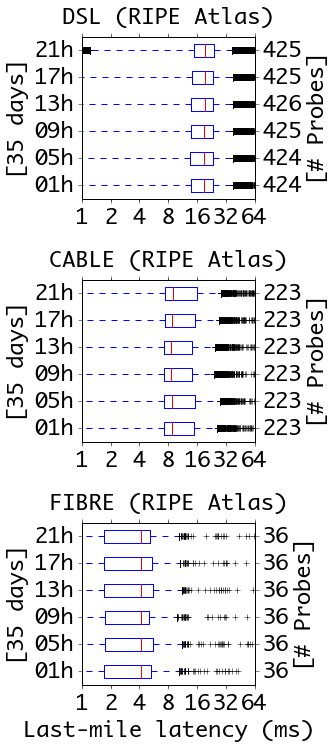

In [307]:
fig = plt.figure(figsize=(3,12))
plt.rcParams['font.size'] = 22

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312, sharex = ax1)
ax3 = fig.add_subplot(313, sharex = ax1)

a  = df_ra_dsl.boxplot (  column='lastmile'
                        , by=['hour']
                        , ax=ax1
                        , vert=False
                       )

stop_plot_box(a, chosen='DSL', count = 0, probes_by_hour = ra_dsl_probes_by_hour, platform = 'RIPE Atlas')

b  = df_ra_cable.boxplot (  column='lastmile'
                        , by=['hour']
                        , ax=ax2
                        , vert=False
                       )

stop_plot_box(b, chosen='CABLE', count = 0, probes_by_hour = ra_cable_probes_by_hour, platform = 'RIPE Atlas')

c  = df_ra_fibre.boxplot (  column='lastmile'
                          , by=['hour']
                          , ax=ax3
                          , vert=False
                         )

stop_plot_box(c, chosen='FIBRE', count = 0, probes_by_hour = ra_fibre_probes_by_hour, platform = 'RIPE Atlas')

xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
plt.setp(xticklabels, visible=True)

fig.subplots_adjust(hspace = 0.5)

ax1.set_xlabel('', fontsize=22)
ax2.set_xlabel('', fontsize=22)

plt.savefig('ra-lastmile-latency-hour-boxplot.pdf', format='pdf', bbox_inches='tight')

In [142]:
del df_ra_dsl['num_probes']; del df_ra_dsl['frac_probes']
del df_ra_cable['num_probes']; del df_ra_cable['frac_probes']
del df_ra_fibre['num_probes']; del df_ra_fibre['frac_probes']

In [143]:
df_ra_cable['tz'] = df_ra_cable['tz'].apply(lambda tz: tz.split('/')[-1].replace('_', ' '))
df_ra_dsl['tz']   = df_ra_dsl['tz'].apply(lambda tz: tz.split('/')[-1].replace('_', ' '))
df_ra_fibre['tz'] = df_ra_fibre['tz'].apply(lambda tz: tz.split('/')[-1].replace('_', ' '))

In [144]:
df_ra_cable_gby_nodename = df_ra_cable.groupby('nodename')
df_ra_dsl_gby_nodename   = df_ra_dsl.groupby('nodename')
df_ra_fibre_gby_nodename = df_ra_fibre.groupby('nodename')

In [145]:
def get_frac_probes_by_nodename_within_tz(provider):

    def num_probes(x):
        probeids = "%s" % ','.join(x)
        return len(set(probeids.split(',')))

    provider_gby   = provider.groupby('tz')
    provider_tz_probes  =   provider_gby['probeid'].agg([num_probes])
    provider_tz_probes  =   provider_gby['probeid'].agg([num_probes])
    provider_tz_probes  =   provider_gby['probeid'].agg([num_probes])
    
    provider  =   pd.merge(provider, provider_tz_probes, left_on='tz', right_index=True)    
    provider_probes    =   len(set(provider['probeid'].values))
    provider['frac_probes']   = provider['num_probes']   / provider_probes
    return provider

In [147]:
for name, provider in df_ra_dsl_gby_nodename:
    
    provider_gby   = provider.groupby('tz')
    probes_by_tz   = ['%d'%len(set(v['probeid'].values)) for k, v in provider_gby]
    if len(probes_by_tz) <= 1: continue
    
    ax = start_plot_box(height=3)

    a  = provider.boxplot (   column='lastmile'
                            , by=['tz']
                            , ax=ax
                            , vert=False
                           )

    stop_plot_box(a, platform = 'RIPE Atlas', chosen=name, count=0
                  , probes_by_hour = probes_by_tz)

In [149]:
def get_tcode_from_tz(tz):
    d = {   'Honolulu'    : 'HST'
          , 'Zurich'      : 'CET'
          , 'Dublin'      : 'GMT'
          , 'Los Angeles' : 'PST'
          , 'New York'    : 'EST'
        }
    
    return d.get(tz, None)
    
df_ra_cable['acode'] = df_ra_cable['tz'].apply(get_tcode_from_tz)

In [151]:
df_ra.head()

,probeid,lastmile,nodename,chosen,tz,datetime,hour
0,10006,20.061,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 13:47:14,13h
1,10006,17.269,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 17:47:12,17h
2,10006,17.338,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-28 21:47:15,21h
3,10006,17.099,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-29 01:47:10,01h
4,10006,17.104,XS4ALL (AS3265),DSL,Europe/Amsterdam,2014-07-29 05:47:11,05h


In [152]:
df_ra_groupby = df_ra.groupby('probeid')
df_ra_agg = df_ra_groupby['lastmile'].agg(['median'])
df_ra_merged = pd.merge(df_ra, df_ra_agg, left_on='probeid', right_index=True)

del df_ra_merged['datetime']
del df_ra_merged['hour']
del df_ra_merged['lastmile']

df_ra_merged = df_ra_merged.drop_duplicates()
df_ra_merged.rename(columns={'median': 'lastmile_median'}, inplace=True)

In [153]:
df_ra_dsl   = df_ra_merged[df_ra_merged.chosen == 'DSL']
df_ra_cable = df_ra_merged[df_ra_merged.chosen == 'CABLE']
df_ra_fibre = df_ra_merged[df_ra_merged.chosen == 'FIBRE']

In [154]:
df_ra_cable['tz'] = df_ra_cable['tz'].apply(lambda tz: tz.split('/')[-1].replace('_', ' '))
df_ra_dsl['tz']   = df_ra_dsl['tz'].apply(lambda tz: tz.split('/')[-1].replace('_', ' '))
df_ra_fibre['tz'] = df_ra_fibre['tz'].apply(lambda tz: tz.split('/')[-1].replace('_', ' '))

/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/vbajpai/.virtualenvs/lastmile-data-collection-analysis-python3/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning

In [155]:
df_ra_cable_gby_nodename = df_ra_cable.groupby('nodename')
df_ra_dsl_gby_nodename = df_ra_cable.groupby('nodename')
df_ra_fibre_gby_nodename = df_ra_cable.groupby('nodename')

In [156]:
def start_plot(fontsize=22, height = 1.5):    
    # ----- plt.style.use('ggplot')
    fig = plt.figure(figsize=(5, height))
    plt.rcParams['font.size'] = fontsize
    ax = fig.add_subplot(111)
    return ax

In [157]:
def stop_plot(ax, chosen, count, fontsize = 22):
    
    xticks = [1, 2, 4, 8, 16, 32, 64]
    yticks = np.arange(0,1.1,0.2)
    #ax.yaxis.set_label_coords(-0.15, 0.45)
    ax.grid(False)
    ax.set_yticks(yticks)
    ax.set_ylim([0,1.05])
    ax.set_xlim([1, 64])    
    ax.set_xscale('log', basex=2)
    ax.set_xlabel('Last-mile latency (ms)', fontsize=fontsize)
    ax.set_ylabel('CDF (%d)'%count, fontsize=fontsize)
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))
    
    plt.xticks(xticks, xticks)
    
    plt.legend(fontsize=12, loc='upper left', ncol=1)    
    plt.title('%s (RIPE Atlas)'%(chosen), fontsize=fontsize, y=1.05)

In [158]:
import Cdf

markers = ['d', 'x', '+', 'o', 'p', 'v', '8', '*', 'D', '<', 's']
colors  = ['Red', 'Blue']

def draw_cdf(df, nodename, index):
    
    sample = df['lastmile_median'].values
    sample = [x for x in sample if x > 0]
    c = Cdf.MakeCdfFromList(sample)
    
    plt.plot (  c.xs
              , c.ps
              , marker=markers[index]
              , linewidth=0.3
              , markersize=5
              , fillstyle='none'
              , color = colors[index]
              , label="%s (%d)"%(nodename, df['probeid'].count())
             )

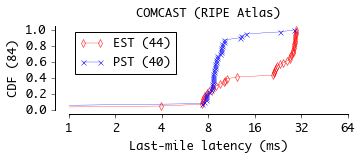

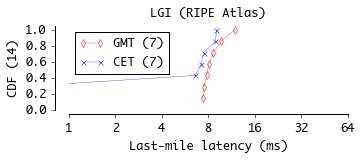

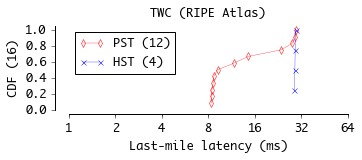

In [159]:
for index, (name, provider) in enumerate(df_ra_cable_gby_nodename):
    
    provider   = get_frac_probes_by_nodename_within_tz(provider)
    provider   = provider[provider['frac_probes'] > 0.20]
    provider['tcode'] = provider['tz'].apply(get_tcode_from_tz)    
    provider_gby   = provider.groupby('tcode')
    provider_count = provider['probeid'].count()
    
    name = name.split(' ')[0]
    
    probes_by_tz   = ['%d'%len(set(v['probeid'].values)) for k, v in provider_gby]
    if len(probes_by_tz) <= 1: continue      # -- skip if provider only in 1 timezone

    ax = start_plot(fontsize = 12)
    name = '%s (RIPE Atlas)'%name
    
    for index, (k, v) in \
    enumerate(sorted(provider_gby.groups.items(), key=lambda x: len(x[1]), reverse=True)):
        groups = provider_gby.get_group(k)
        probes = groups['probeid'].count()
        try: draw_cdf(groups, k, index)
        except Exception as e: print(e, k, groups['probeid'].count())
    
    stop_plot(ax=ax, count=provider_count, chosen=name, fontsize = 12)
    
    plt.title('%s'%(name), fontsize=12, y=1.05)
    name = name.split()[0]
    plt.savefig('ra-%s-lastmile-latency-cdf.pdf'%name, format='pdf', bbox_inches='tight')
    name = name.split(' ')[0]